author: @SteveEckel

This example covers calculating the forces in a one-dimensional optical molasses
using the optical bloch equations.  It reproduces Fig. 1 of Devlin, J. A. and
Tarbutt, M. R. (2016) ‘Three-dimensional Doppler, polarization-gradient, and
magneto-optical forces for atoms and molecules with dark states’, New Journal of
Physics, 18(12), p. 123017. doi: 10.1088/1367-2630/18/12/123017.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.tools
import copy
import time
import cProfile, pstats, io
#plt.style.use('paper')

First, define the laser beams:

In [5]:
det = -2.5
beta = 1.0

laserBeams = {}
laserBeams['$\\sigma^+\\sigma^-$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':0, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'spherical', 'delta':0, 'beta':beta},
    ])

phi = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
phi_keys = ['$\phi=0$', '$\phi=\pi/8$', '$\phi=\pi/4$', '$\phi=3\pi/8$', '$\phi=\pi/2$']
for phi_i, key_beam in zip(phi, phi_keys):
    laserBeams[key_beam] = pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
         'pol_coord':'cartesian', 'delta':0, 'beta':beta},
        {'kvec':np.array([0., 0., -1.]),
         'pol':np.array([np.cos(phi_i), np.sin(phi_i), 0.]),
         'pol_coord':'cartesian', 'delta':0, 'beta':beta}
        ])

hamiltonian = {}
for Fg, Fe in zip([1, 1, 2], [2, 1, 1]):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fg, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fe, gF=1/Fe, muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fg, Fe)
    hamiltonian['Fg%d;Fe%d'%(Fg,Fe)] = pylcp.hamiltonian(
        Hg, He - det*np.eye(2*Fe+1), Bgq, Beq, dijq
        )

magField = lambda R: np.zeros(R.shape)


Next, run the OBEs:

In [6]:
obe = {}
v = np.concatenate((np.arange(0.0, 0.1, 0.001),
                    np.arange(0.1, 5.1, 0.1)))
#v = np.arange(-0.1, 0.1, 0.01)
tic = time.time()

pr = cProfile.Profile()

for key_ham in hamiltonian.keys():
    if key_ham not in obe.keys():
        obe[key_ham] = {}

    for key_beam in laserBeams.keys():
        print('Running %s w/ %s' % (key_ham, key_beam) + '...')
        obe[key_ham][key_beam] = pylcp.obe(laserBeams[key_beam],
                                           magField, hamiltonian[key_ham],
                                           transform_into_re_im=True,
                                           use_sparse_matrices=False)

        tic_inner=time.time()
        pr.enable()
        obe[key_ham][key_beam].generate_force_profile(
            [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
            [np.zeros(v.shape), np.zeros(v.shape), v],
            name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
            rel=1e-8, abs=1e-10, progress_bar=True
        )
        pr.disable()
        toc_inner=time.time()
        print('Computation time w/ %s and %s: %.3f s.' % (key_ham, key_beam,
                                                          toc_inner-tic_inner))

toc=time.time()
print('Total computation time %d s.'%(toc-tic))


Running Fg1;Fe2 w/ $\sigma^+\sigma^-$...
Completed in 1:08:49.                                               
Computation time w/ Fg1;Fe2 and $\sigma^+\sigma^-$: 4129.373 s.
Running Fg1;Fe2 w/ $\phi=0$...
Completed in 29:46.                                                 
Computation time w/ Fg1;Fe2 and $\phi=0$: 1786.171 s.
Running Fg1;Fe2 w/ $\phi=\pi/8$...
Completed in 19:24.                                                 
Computation time w/ Fg1;Fe2 and $\phi=\pi/8$: 1164.509 s.
Running Fg1;Fe2 w/ $\phi=\pi/4$...
Completed in 17:41.                                                 
Computation time w/ Fg1;Fe2 and $\phi=\pi/4$: 1061.278 s.
Running Fg1;Fe2 w/ $\phi=3\pi/8$...
Completed in 9:56.                                                  
Computation time w/ Fg1;Fe2 and $\phi=3\pi/8$: 596.846 s.
Running Fg1;Fe2 w/ $\phi=\pi/2$...
Completed in 8:33.                                                  
Computation time w/ Fg1;Fe2 and $\phi=\pi/2$: 513.862 s.
Running Fg1;Fe1 w/ $\sig

Benchmarks:

Steve's iMac, 9/17/19:

v = np.concatenate((np.arange(0.0, 0.1, 0.001),
                    np.arange(0.1, 5.1, 0.1)))

obe[key_ham][key_beam].generate_force_profile(
    [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
    [np.zeros(v.shape), np.zeros(v.shape), v],
    name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
    rel=1e-8, abs=1e-10, progress_bar=True, use_jit=True
)

Computation time w/ Fg1;Fe2 and $\sigma^+\sigma^-$: 242.554 s.

Computation time w/ Fg1;Fe2 and $\phi=0$: 198.940 s.

Computation time w/ Fg1;Fe2 and $\phi=\pi/8$: 211.727 s.

Computation time w/ Fg1;Fe2 and $\phi=\pi/4$: 222.040 s.

Computation time w/ Fg1;Fe2 and $\phi=3\pi/8$: 224.027 s.

Computation time w/ Fg1;Fe2 and $\phi=\pi/2$: 227.515 s.

Computation time w/ Fg1;Fe1 and $\sigma^+\sigma^-$: 135.895 s.

Computation time w/ Fg1;Fe1 and $\phi=0$: 173.920 s.

Computation time w/ Fg1;Fe1 and $\phi=\pi/8$: 176.254 s.

Computation time w/ Fg1;Fe1 and $\phi=\pi/4$: 169.078 s.

Computation time w/ Fg1;Fe1 and $\phi=3\pi/8$: 155.653 s.

Computation time w/ Fg1;Fe1 and $\phi=\pi/2$: 158.043 s.

Computation time w/ Fg2;Fe1 and $\sigma^+\sigma^-$: 230.381 s.

Computation time w/ Fg2;Fe1 and $\phi=0$: 286.115 s.

Computation time w/ Fg2;Fe1 and $\phi=\pi/8$: 288.890 s.

Computation time w/ Fg2;Fe1 and $\phi=\pi/4$: 276.927 s.

Computation time w/ Fg2;Fe1 and $\phi=3\pi/8$: 285.176 s.

Computation time w/ Fg2;Fe1 and $\phi=\pi/2$: 278.543 s.

Total computation time -3941 s.


Print out the profile results:

In [7]:
s = io.StringIO()
sortby = 'cumtime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         3448057340 function calls (3435949783 primitive calls) in 18385.663 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18    1.688    0.094 18385.664 1021.426 C:\Users\sheik\Documents\GitHub\pylcp\obe.py:898(generate_force_profile)
     2700    9.942    0.004 18369.193    6.803 C:\Users\sheik\Documents\GitHub\pylcp\obe.py:841(find_equilibrium_force)
    27358    0.559    0.000 17384.685    0.635 C:\Users\sheik\Documents\GitHub\pylcp\obe.py:595(evolve_density)
    27358   94.567    0.003 16342.795    0.597 C:\Users\sheik\anaconda3\lib\site-packages\scipy\integrate\_ivp\ivp.py:157(solve_ivp)
  6803158   32.113    0.000 15341.771    0.002 C:\Users\sheik\anaconda3\lib\site-packages\scipy\integrate\_ivp\base.py:160(step)
  6803158  248.567    0.000 15309.657    0.002 C:\Users\sheik\anaconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:112(_step_impl)
  7031157  572.953    0.000 14742.827    0.002 C:\Users\sheik\a

Plot 'er up:

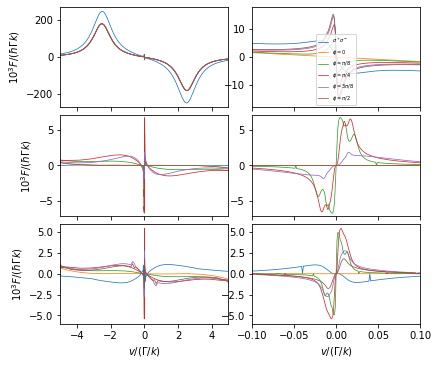

In [8]:
fig, ax = plt.subplots(3, 2, num='F=1->F=2', figsize=(6.25, 2*2.75))

ylims = [[270, 7, 6], [18, 7, 6]]
for ii, key_ham in enumerate(hamiltonian.keys()):
    for key_beam in laserBeams.keys():
        ax[ii, 0].plot(np.concatenate((-v[::-1], v)),
                        1e3*np.concatenate(
                            (-obe[key_ham][key_beam].profile['molasses'].F[2][::-1],
                             obe[key_ham][key_beam].profile['molasses'].F[2])
                            ),
                       label=key_beam, linewidth=0.75)
        ax[ii, 1].plot(np.concatenate((-v[::-1], v)),
                        1e3*np.concatenate(
                            (-obe[key_ham][key_beam].profile['molasses'].F[2][::-1],
                             obe[key_ham][key_beam].profile['molasses'].F[2])
                            ),
                       label=key_beam, linewidth=0.75)

    ax[ii, 0].set_xlim((-5, 5))
    ax[ii, 1].set_xlim((-0.1, 0.1))
    ax[ii, 0].set_ylim((-ylims[0][ii], ylims[0][ii]))
    ax[ii, 1].set_ylim((-ylims[1][ii], ylims[1][ii]))

ax[-1, 0].set_xlabel('$v/(\Gamma/k)$')
ax[-1, 1].set_xlabel('$v/(\Gamma/k)$')
for ii in range(len(hamiltonian)):
    ax[ii, 0].set_ylabel('$10^3 F/(\hbar\Gamma k)$')

for ii in range(len(hamiltonian)-1):
    for jj in range(2):
        ax[ii, jj].set_xticklabels([])

ax[0, 1].legend(fontsize=5)
fig.subplots_adjust(wspace=0.14, hspace=0.08, left=0.1, bottom=0.08)

#fig.savefig('02_F_to_Fp_1D_molasses.pdf')


Look at a particular solution at a particular velocity:

In [10]:
key_ham = 'Fg1;Fe1'
key_laser = '$\phi=0$'

obe = pylcp.obe(laserBeams[key_beam], magField, hamiltonian[key_ham],
                    transform_into_re_im=True)

v_i = -5

r0 = 100*(np.random.random(size=(3,))-5)
v0 = np.array([0., 0., v_i])
obe.set_initial_position_and_velocity(r0, v0)
obe.set_initial_rho_from_rateeq()
obe.find_equilibrium_force(
    deltat=2*np.pi*1/np.abs(v_i), itermax=5, debug=True,
    rel=1e-8, abs=1e-10, use_jit=True, Npts=5001
)

t_eval = np.linspace(0, obe.piecewise_sols[-1].t[-1],
                     len(obe.piecewise_sols)*5000+1)
obe.set_initial_position_and_velocity(r0, v0)
obe.set_initial_rho_from_rateeq()
obe.evolve_density([0., t_eval[-1]], t_eval=t_eval)

print(obe.sol.y[15, -1], obe.piecewise_sols[-1].y[15, -1])

(t, rho) = obe.reshape_sol()
f = obe.force_from_sol()[2]

fig, ax = plt.subplots(2, 2, figsize=(6.5, 4.5))

ax[0, 0].plot(t, rho[0, 0], color='C0', linewidth=0.5, alpha=0.5)
ax[0, 0].plot(t, rho[1, 1], color='C1', linewidth=0.5, alpha=0.5)
ax[0, 0].plot(t, rho[2, 2], color='C2', linewidth=0.5, alpha=0.5)

ax[0, 1].plot(t, rho[3, 3], color='C0', linewidth=0.5, alpha=0.5)
ax[0, 1].plot(t, rho[4, 4], color='C1', linewidth=0.5, alpha=0.5)
ax[0, 1].plot(t, rho[5, 5], color='C2', linewidth=0.5, alpha=0.5)

ax[1, 0].plot(t, np.abs(rho[0, 1]), color='C0', linewidth=0.5, alpha=0.5)
ax[1, 0].plot(t, np.abs(rho[0, 2]), color='C1', linewidth=0.5, alpha=0.5)
ax[1, 0].plot(t, np.abs(rho[1, 2]), color='C2', linewidth=0.5, alpha=0.5)

ax[1, 0].plot(t, np.abs(rho[0, 1]), color='C0', linewidth=0.5, alpha=0.5)
ax[1, 0].plot(t, np.abs(rho[0, 2]), color='C1', linewidth=0.5, alpha=0.5)
ax[1, 0].plot(t, np.abs(rho[1, 2]), color='C2', linewidth=0.5, alpha=0.5)

ax[1, 1].plot(t, f, linewidth=0.5, alpha=0.5)

for jj in range(len(obe.piecewise_sols)):
    obe.sol = obe.piecewise_sols[jj]
    t = obe.sol.t
    rho = obe.reshape_sol()
    f = obe.force_from_sol()[2]

    ax[0, 0].plot(t, rho[0, 0], '--', color='C0', linewidth=0.5)
    ax[0, 0].plot(t, rho[1, 1], '--', color='C1', linewidth=0.5)
    ax[0, 0].plot(t, rho[2, 2], '--', color='C2', linewidth=0.5)

    ax[0, 1].plot(t, rho[3, 3], '--', color='C0', linewidth=0.5)
    ax[0, 1].plot(t, rho[4, 4], '--', color='C1', linewidth=0.5)
    ax[0, 1].plot(t, rho[5, 5], '--', color='C2', linewidth=0.5)

    ax[1, 0].plot(t, np.abs(rho[0, 1]), '--', color='C0', linewidth=0.5)
    ax[1, 0].plot(t, np.abs(rho[0, 2]), '--', color='C1', linewidth=0.5)
    ax[1, 0].plot(t, np.abs(rho[1, 2]), '--', color='C2', linewidth=0.5)

    ax[1, 1].plot(t, f, '--', color='C0', linewidth=0.5)
"""v_i = -5.
tmax = 10000*np.pi/np.abs(v_i)

obe[key_ham][key_laser].set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                                          np.array([0., 0., v_i]))
obe[key_ham][key_laser].set_initial_rho_from_rateeq()
obe[key_ham][key_laser].evolve_density(t_span=[0, tmax])
ftime = obe[key_ham][key_laser].force_from_sol()
rho = obe[key_ham][key_laser].reshape_sol()

lines = ['-', '--']
fig, ax = plt.subplots(2, 2, num='OBE F=0->F1', figsize=(6.25, 5.5))

for ii in range(3):
    ax[0, 0].plot(obe[key_ham][key_laser].sol.t,
                  np.abs(rho[:, ii, ii]),
                  color='C%d' % ii,
                  label='$\\rho_{g%d,g%d}$' % (ii, ii), linewidth=0.75)
ax[0, 0].legend(fontsize=6)

for ii in range(3):
    ax[0, 1].plot(obe[key_ham][key_laser].sol.t,
                  np.abs(rho[:, 3+ii, 3+ii]),
                  color='C%d' % ii,
                  label='$\\rho_{e%d,e%d}$' % (ii, ii), linewidth=0.75)
ax[0, 1].legend(fontsize=6)


ax[1, 0].plot(obe[key_ham][key_laser].sol.t,
              np.real(rho[:, 0, 2]),
              color='C0',
              label='Re$[\\rho_{g0,g2}]$', linewidth=0.75)
ax[1, 0].plot(obe[key_ham][key_laser].sol.t,
              np.imag(rho[:, 0, 2]),
              '--', color='C0',
              label='Im[$\\rho_{g0,g2}]$', linewidth=0.75)
ax[1, 0].legend(fontsize=6)

ax[1, 1].plot(obe[key_ham][key_laser].sol.t, ftime[2, :])
ftime[:, -1]"""


Finding equilbrium force at r=(-464.84, -496.89, -443.42) v=(0.00, 0.00, -5.00) with deltat = 1.26, itermax = 5, Npts = 5001, rel = 1.0e-08 and abs = 1.0e-10
0 [0.        0.        0.0132658] 0.0001759813642715157
1 [ 0.          0.         -0.00078896] 6.224650959063269e-07


C:\Users\sheik\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `use_jit`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


2 [0.         0.         0.00672085] 4.516980378339606e-05
3 [0.         0.         0.00262046] 6.866799894223449e-06
4 [0.         0.         0.00477803] 2.282954988804532e-05


AttributeError: 'NoneType' object has no attribute 'rho'